<a href="https://colab.research.google.com/github/sazio/Transients/blob/master/Python/Trajectories%26Levy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install traja

     |████████████████████████████████| 81kB 3.5MB/s 
  Created wheel for traja: filename=traja-0.2.3-cp36-none-any.whl size=82654 sha256=5d1b4a4ad839b3c550694d984bae03c88907d145a9ceae8700e028fbc8e27912
  Stored in directory: /root/.cache/pip/wheels/03/90/1a/84e9bb38d095fd62bff931244bb861c2eeec6f3b79dd03d945
Successfully built traja


In [483]:
import numpy as np
import pandas as pd 
import traja
import glob
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [484]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [485]:
path_to_files = "drive/MyDrive/JamesSimoneSpatial/TrackFilesCue/CueCsv/Track/"

trackFiles = []
trackFiles = sorted(glob.glob(path_to_files + '*Track.csv'))

In [486]:
probeFiles = []

# Filtering probe trials 
# if probeFilter = True, probetrials are not used in the future statistics
# if probeFilter = False, probetrials are going to take part in the stats
probeFilter = True 

if probeFilter == True:
    regExpr = re.compile(r'p_Track')
    probeFiles = list(filter(lambda i : regExpr.search(i), trackFiles))
    trackFiles = list(filter(lambda i : not regExpr.search(i), trackFiles))
    
else : 
    trackFiles = trackFiles 

In [487]:
trackData = []
for i in tqdm(range(0,len(trackFiles))) : 
    trackData.append(pd.read_csv(trackFiles[i], names = ["time", "x", "y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""

In [488]:
# Creating list of probe Data as list of pandas dataframes 
probeData = []
for i in tqdm(range(0,len(probeFiles))) : 
    probeData.append(pd.read_csv(probeFiles[i], names = ["time", "x", "y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))

In [489]:
trackData[0]

,time,x,y,HeadAngle,EODRate,DistanceXEODPulse,HeadSpeed,DistanceXESCAN
0,147.55,0.446080,0.243920,261.62,74.836,0.000000e+00,0.000000,0.000111
1,147.56,0.446080,0.243920,261.24,74.836,0.000000e+00,0.000000,0.002028
2,147.57,0.446080,0.243920,260.87,74.799,-1.045000e-10,0.000000,0.004012
3,147.58,0.446080,0.243920,260.50,74.707,-1.730700e-09,0.000000,0.006063
4,147.59,0.446080,0.243920,260.12,74.563,-4.686400e-09,0.000000,0.008181
...,...,...,...,...,...,...,...,...
6201,209.56,-0.000624,-0.100440,175.90,82.714,1.120700e-03,-0.092697,0.044031
6202,209.57,0.000170,-0.099966,175.00,82.301,1.126300e-03,-0.092697,0.044691
6203,209.58,0.000964,-0.099488,174.10,81.900,1.131800e-03,-0.092697,0.045335
6204,209.59,0.001758,-0.099010,173.21,81.784,1.134400e-03,-0.092697,0.045964


In [490]:
traja_steps = []
for i in tqdm(range(0, len(trackFiles[:19]))):

  trajaDF = traja.TrajaDataFrame(trackData[i])
  #trajaDF = traja.TrajaDataFrame(trackData[i].iloc[::10,:])
  pivot = traja.step_lengths(trajaDF).dropna()
  pivot = pivot[pivot!= 0]

  traja_steps.append(pivot)

In [505]:
early_steps = traja_steps[0]

for i in tqdm(range(1,17)):
  early_steps = early_steps.append(traja_steps[i], ignore_index= True)

In [492]:
trackCurvData = []
for i in tqdm(range(0,len(trackFiles[:19]))):  
  trackCurvData.append(traja.rediscretize_points(trackData[i], R = 0.013)) # R = 0.013 is the step length , threshold of the previous distribution

In [493]:
early_curv = np.abs(traja.trajectory.calc_turn_angle(trackCurvData[0]).dropna())
for i in tqdm(range(1, len(trackCurvData))):
  early_curv.append(np.abs(traja.trajectory.calc_turn_angle(trackCurvData[i]).dropna()))

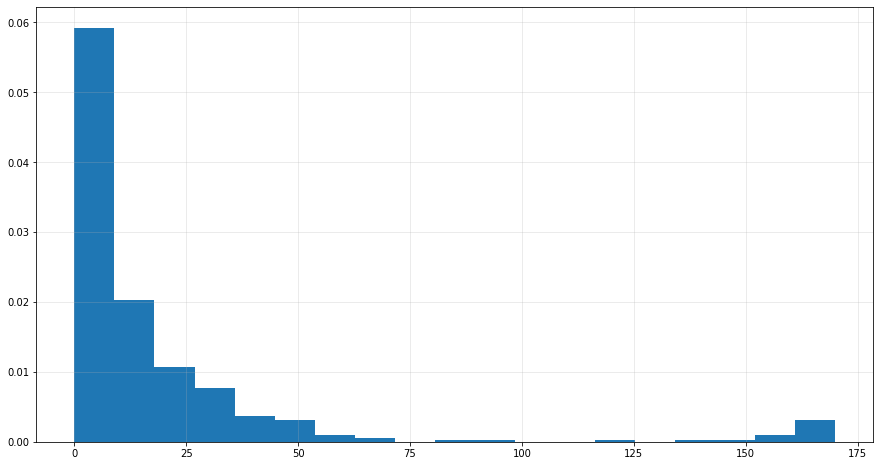

In [494]:
plt.figure(figsize = (15,8))
counts, bins, bars =  plt.hist(early_curv, bins = int(np.sqrt(early_curv.shape[0])), density = True)
#plt.ylim([0,50])
#plt.xlim([0,10])
plt.grid(alpha = 0.3)

In [506]:
l_0 = 0.0013
n_trials = 19
early_steps = early_steps*10000#[early_steps > l_0]*10000

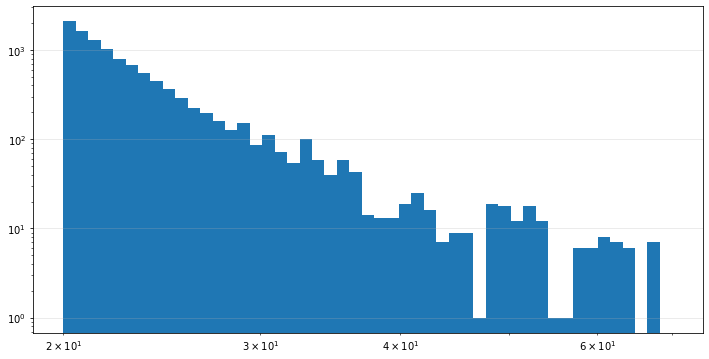

In [520]:
plt.figure(figsize = (12,6))

#
counts, bins, bars = plt.hist(early_steps,bins=np.logspace(np.log10(20),np.log10(70), 50), log = True)#int(np.sqrt(early_steps.shape[0])))
#counts, bins, bars = plt.hist(np.log10(early_steps), bins = int(np.sqrt(early_steps.shape[0])), log = True)
plt.gca().set_xscale("log")
plt.grid(alpha = 0.3)
#plt.savefig("distrib_early.png")

In [440]:
from scipy import stats

In [523]:
# Flight-length percentage
counts = counts/np.linalg.norm(counts, ord=1)*100#*100

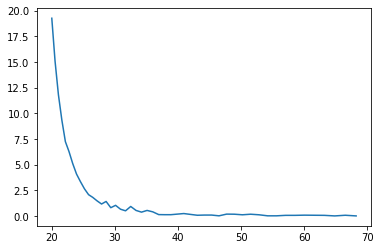

In [524]:
plt.plot(bins[:-1], counts)

In [443]:
"""plt.plot(bins[:-1] -12.5, counts*10)
y = st.levy.pdf(bins[:-1]-12.5,*st.levy._fitstart(bins[:-1]-12.5))
l = plt.plot(bins[:-1]-12.5, y, 'r--', linewidth=2)
""";

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


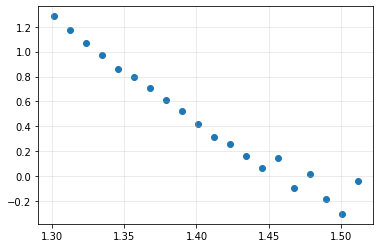

In [530]:
x_fit = np.log10(bins[:-1])[:20]
y_fit = np.log10(counts)[:20]
plt.scatter(x_fit, y_fit)
plt.grid(alpha = 0.3)

In [531]:
"""x_ = np.log10(bins[:-1])
y_ = np.log10(counts)
plt.plot(np.log10(bins[:-1]), np.log10(counts))
plt.grid(alpha = 0.3)""";

In [532]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_fit,y_fit)

In [533]:
print(slope, intercept, r_value, p_value, std_err)

-7.148010682267216 10.491999012789162 -0.9824135876787505 1.433979879959191e-14 0.3202140166285742


In [143]:
import scipy.stats as st
from scipy.optimize import curve_fit

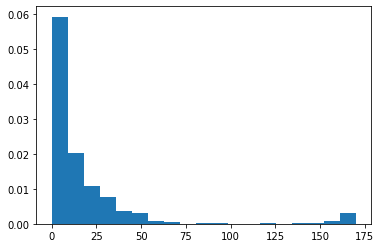

In [ ]:
counts, bins, bars =  plt.hist(early_curv, bins = int(np.sqrt(early_curv.shape[0])) , density = True)

In [ ]:
popt, pcov = curve_fit(levy_distrib, bins[:-1], counts)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


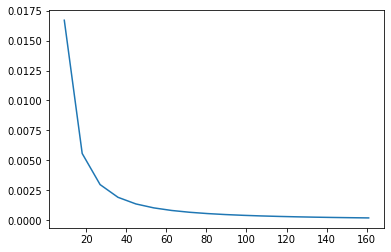

In [ ]:
plt.plot(bins[:-1], levy_distrib(bins[:-1], *popt))

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


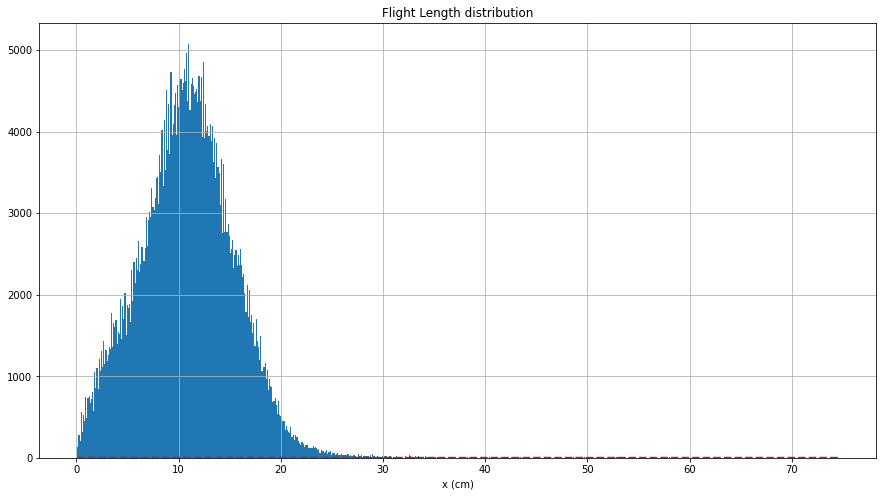

In [182]:
plt.figure(figsize = (15,8))
#n, bins, patches = plt.hist(x, int(np.sqrt(x.shape[0])), density = True, facecolor='green', alpha=0.55)
#counts, bins, bars =  plt.hist(early_curv, bins = int(np.sqrt(early_curv.shape[0])), density = True)
#counts, bins, bars = plt.hist(early_steps*2000, bins = int(np.sqrt(early_steps.shape[0])), density = True, facecolor='green', alpha=0.55)
#counts, bins, bars =  plt.hist(early_curv, bins = int(np.sqrt(early_curv.shape[0])))#, density = True)

counts, bins, bars = plt.hist(early_steps, int(np.sqrt(early_steps.shape[0])))
#counts = counts/np.linalg.norm(counts, ord=1)

# add a 'best fit' line
#y = norm.pdf( bins, *norm._fitstart(bins))
y = st.levy.pdf(bins,*st.levy._fitstart(bins))

l = plt.plot(bins, y, 'r--', linewidth=2)


plt.title("Flight Length distribution")
plt.xlabel('x (cm)')
plt.ylabel('')

plt.grid(True)

plt.show()

## Mouse